# LA-ICP-MS dataset processing
## required packets

In [1]:
from process_image import *

## basic settings
set some basic infos for the image procesing

In [2]:
settings = getBaseSettings()

# show debugging output
settings["showDebuggingOutput"] = True
# set the physical spot distance in µm
#settings["spot_distance_x"]     = 7.0
#settings["spot_distance_y"]     = 0.579150579150579

## export map AB4 Bereich 2
settings["spot_distance_x"]     = 6.312183673469388
settings["spot_distance_y"]     = 0.5892393822393822

# change interpolation between the lines in x direction [integer, 0 disables this option]
settings["stretch_x"]           = 6
# set the gaussian filter size in y direction [integer, 0 disables this option]
settings["smooth_y"]            = 3

## set the data source
select the datasource - if load_raw = True, the script expects a path to the raw dataset consisting of multiple *.xl files. Else, the script expects an excel file with multiple sheets.

If no `workingDirectory` or `excel_file` is set, the script opens a file dialog.


In [3]:
settings["load_raw"]     = True
settings["workingDirectory"] = settings["home_dir"] + os.sep + "example_data" + os.sep + "raw format" + os.sep

settings["load_raw"]   = False
settings["excel_file"] = settings["home_dir"] + os.sep + "example_data" + os.sep + "excel_example.xlsx"

In [4]:
laser_data = LA_ICP_MS_LOADER(settings)

Selected working directory: D:\GIT\LA-ICP-MS\example_data\raw format\
loaded a dataset with the dimensions of 50 x 519 datapoints and 11 elements:
['²³Na', '²⁴Mg', '²⁷Al', '³⁹K', '⁴⁷Ti', '⁵¹V', '⁵²Cr', '⁵⁵Mn', '⁶⁶Zn', '⁸⁷Rb', '¹³⁷Ba']


# set calibration data if available

this dictionary requires the calibration factor for ppm in [signal / ppm]

Since the oxide form of every element has to be known, there is only a limited amount of known elements:

In [5]:
print('Known elements for calibration: ')
s = ''
for element in laser_data.oxide_dict: s += element+', '
print( s )


Known elements for calibration: 
Na, Mg, Al, K, Ti, V, Cr, Mn, Zn, Rb, Ba, Ca, Sr, P, Cu, Ni, Pb, As, 


In [6]:
calibration_area_2 = {
    "Na23":   1.171,
    "Mg24":   3.953,
    "Al27":   2.711,
    "K39":    9.495,
    "Ti47":   0.488,
    "V51":    5.701,
    "Cr52":   4.876,
    "Mn55":   5.554,
    "Zn66":   0.527,
    "Rb87":  18.741,
    "Ba137":  0.391
}

calibration_area_3 = {
    "Na23":   2.502,
    "Mg24":   6.373,
    "Al27":   4.361,
    "K39":    8.945,
    "Ti47":   0.796,
    "V51":    8.401,
    "Cr52":   5.959,
    "Mn55":  10.281,
    "Zn66":   0.801,
    "Rb87":  27.477,
    "Ba137":  0.771
}

laser_data.set_calibration_dictionary( calibration_area_3 )

# show an example image (first element in the set)

array([[0.        , 0.0053642 , 0.0107284 , ..., 0.05999435, 0.05321852,
        0.04644269],
       [0.        , 0.00564653, 0.01129305, ..., 0.06507623, 0.05773574,
        0.05039526],
       [0.        , 0.00621118, 0.01242236, ..., 0.074393  , 0.0663467 ,
        0.0583004 ],
       ...,
       [0.06422925, 0.09387352, 0.12351779, ..., 0.15287973, 0.1391869 ,
        0.12549407],
       [0.05335968, 0.08639187, 0.11942405, ..., 0.13325805, 0.11900056,
        0.10474308],
       [0.04841897, 0.08314512, 0.11787126, ..., 0.12125918, 0.1065782 ,
        0.09189723]])

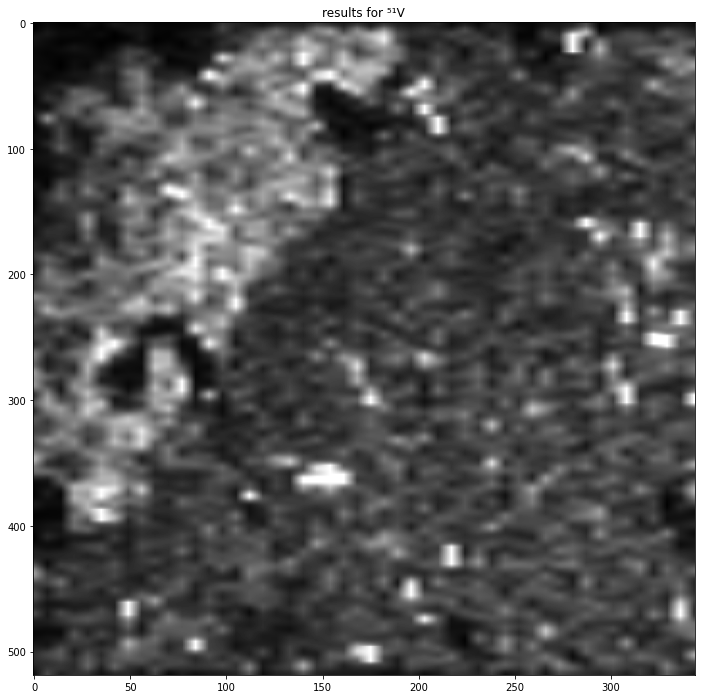

In [7]:
laser_data.show_single_image(element='V51')

## show in the napari viewer
A new window will open. Cell execution will continue in between.

In [8]:
selected_elements = ['Na23', 'Rb85', 'Ti47']
laser_data.show_image_set() # selected_elements

## saving images
uncomment the following line if the results should be saved

In [9]:
# laser_data.save_images()

# experiments with superpixels for segmentation
the following code is work in progress!

In [10]:
import cv2
import matplotlib.pyplot as plt
from skimage.filters import threshold_multiotsu
from skimage.segmentation import slic, mark_boundaries
from skimage import color
from skimage.io import imsave
from matplotlib.colors import LinearSegmentedColormap
import napari

In [11]:
element = laser_data.get_first_element()
def process_SLIC_of_element(element, multi_otsu_class_cnt = 4, show_results=False):
    img, _ = laser_data.optimize_img( laser_data.images[element] )

    img_8bit = img * 255
    img_8bit = img_8bit.astype(np.uint8)
    denoised = cv2.fastNlMeansDenoising( img_8bit, 13, 19, 35 )

    segments_slic = slic(denoised, n_segments=330, compactness=0.15, sigma=1,
                        start_label=1)

    mean_slic = color.rgb2gray( color.label2rgb(segments_slic, img, kind='avg', bg_label=0) )
    
    thresholds = threshold_multiotsu(mean_slic, classes=multi_otsu_class_cnt)

    # Using the threshold values, we generate the three regions.
    regions = np.digitize(mean_slic, bins=thresholds)

    if show_results:
        # Show the segmentations.
        fig, axes = plt.subplots(ncols=5, nrows=1, figsize=(18, 7), sharex=True, sharey=True)
        ax = axes.ravel()
        cmap = laser_data.get_color_by_element(element, napari_cmap=False)

        #colors = [(0, 0, 0), (1, 0, 0)] # first color is black, last is red
        #cmap = LinearSegmentedColormap.from_list(
        #        "Custom", colors, N=256)
        
        
        imsave('image{}.png'.format(element), img)
        ax[0].imshow(img, aspect=laser_data.spot_distance_y/laser_data.spot_distance_x, cmap=cmap, interpolation=None);
        ax[0].set_title('Image [{}]'.format(laser_data.elements[element]))

        ax[1].imshow(denoised, aspect=laser_data.spot_distance_y/laser_data.spot_distance_x, cmap=cmap, interpolation=None);
        ax[1].set_title('denoised')

        ax[2].imshow(mark_boundaries(img, segments_slic), aspect=laser_data.spot_distance_y/laser_data.spot_distance_x, cmap=cmap, interpolation=None) #
        ax[2].set_title('SLIC superpixels')

        ax[3].imshow(mean_slic, aspect=laser_data.spot_distance_y/laser_data.spot_distance_x, cmap=cmap, interpolation=None);
        ax[3].set_title('mean values in slic')

        ax[4].imshow(regions, aspect=laser_data.spot_distance_y/laser_data.spot_distance_x, cmap=cmap, interpolation=None)
        ax[4].set_title('multi-otsu ({}x)'.format(multi_otsu_class_cnt))

        for a in ax:
            a.axis('off')
        fig.tight_layout()
        plt.show()
    
    return denoised, segments_slic, mean_slic, regions


In [12]:
print(laser_data.image_dimensions)

(305.8152393822394, 310.19874052478133, 'µm')


start processing slic segments for simplified segmentation


<ipython-input-11-0a9a66ef6109>:12: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  mean_slic = color.rgb2gray( color.label2rgb(segments_slic, img, kind='avg', bg_label=0) )
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


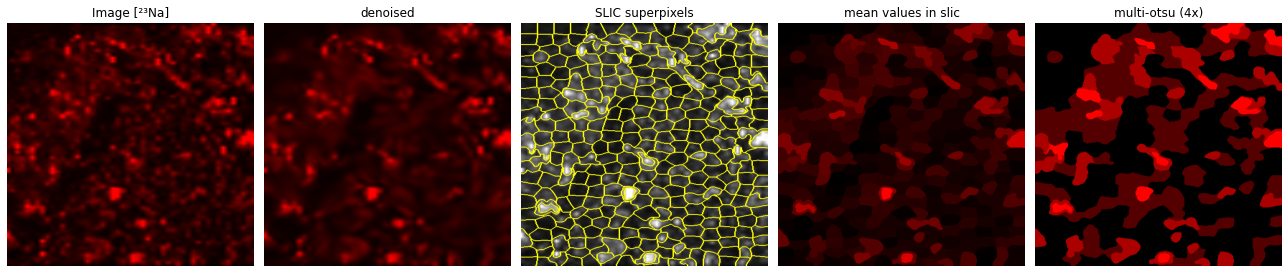

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


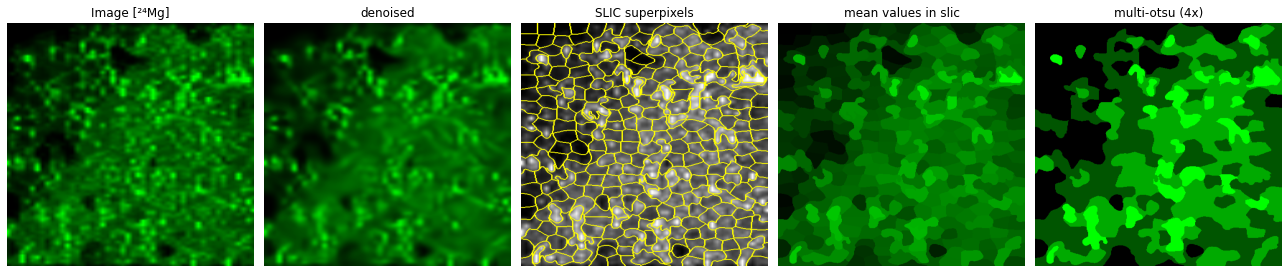

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


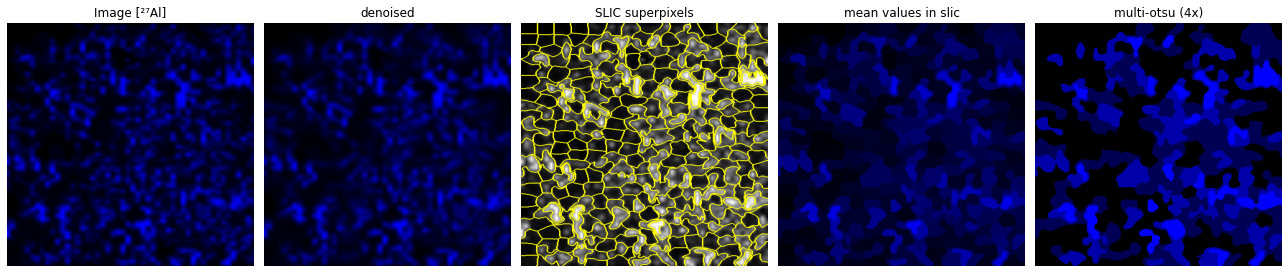

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


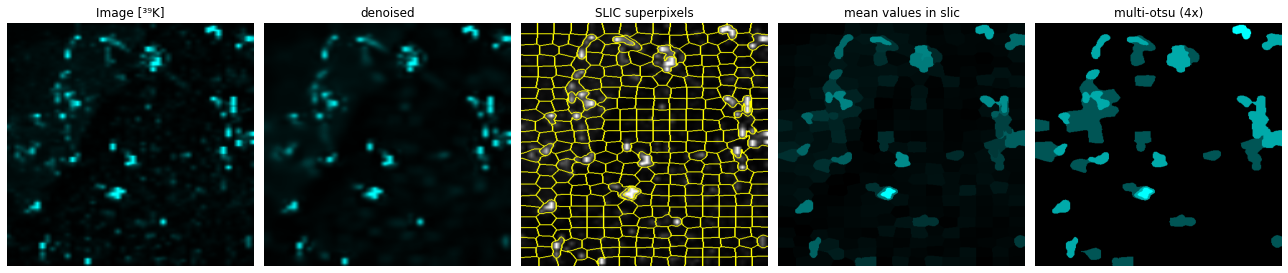

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


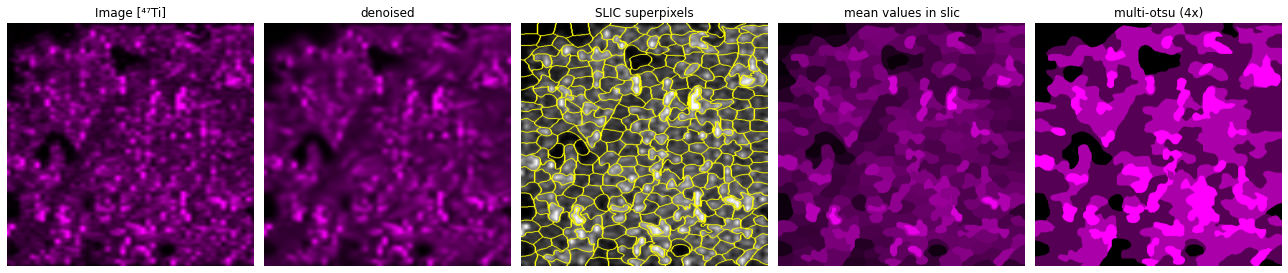

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


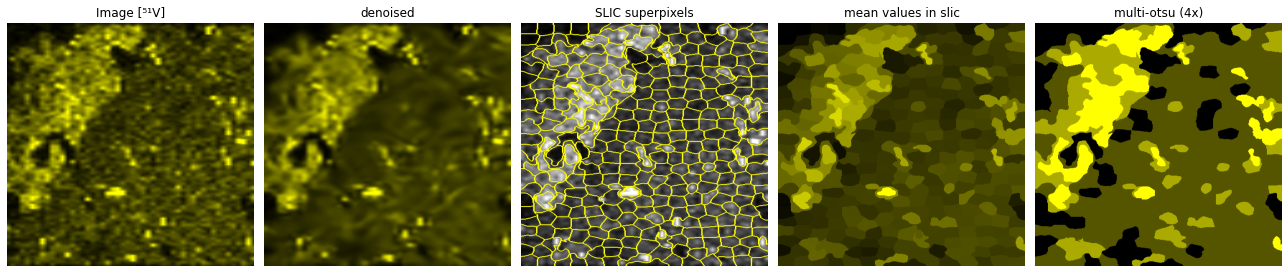

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


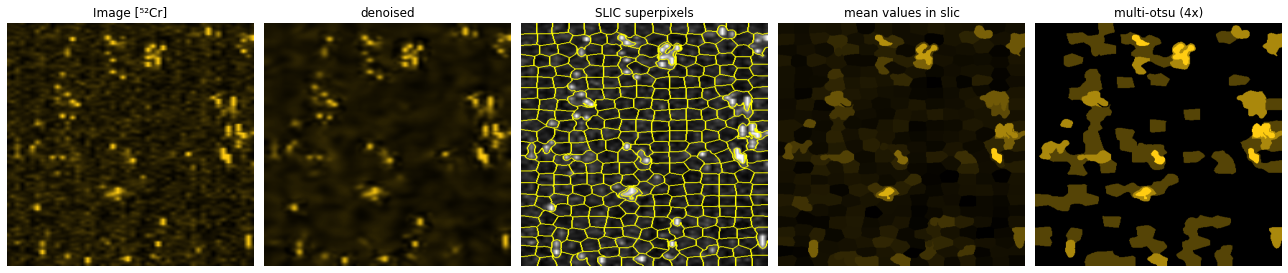

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


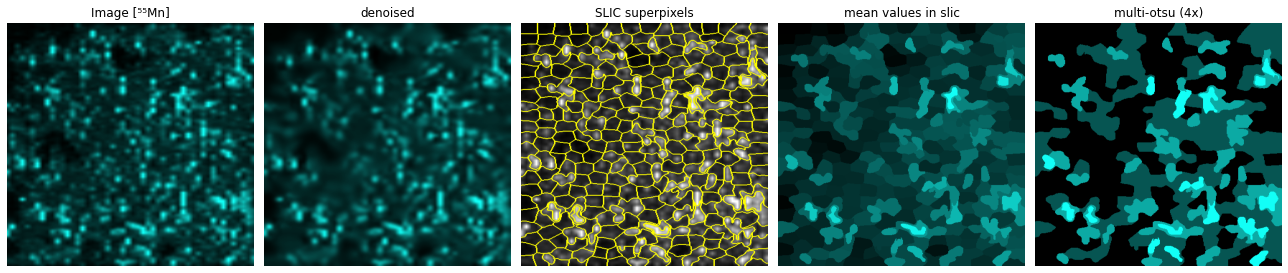

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


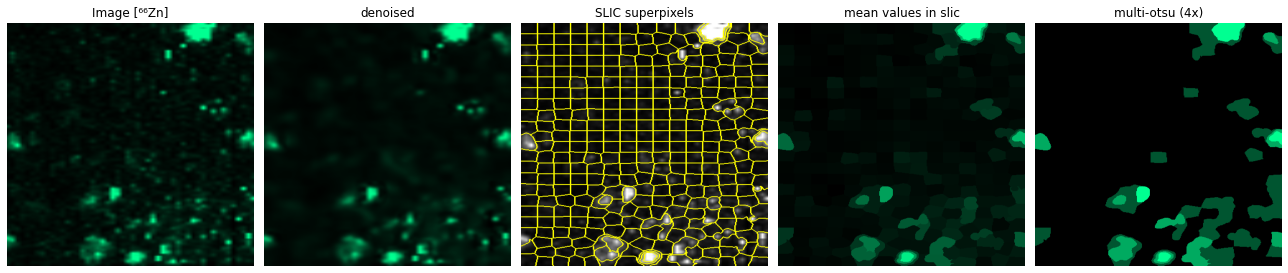

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


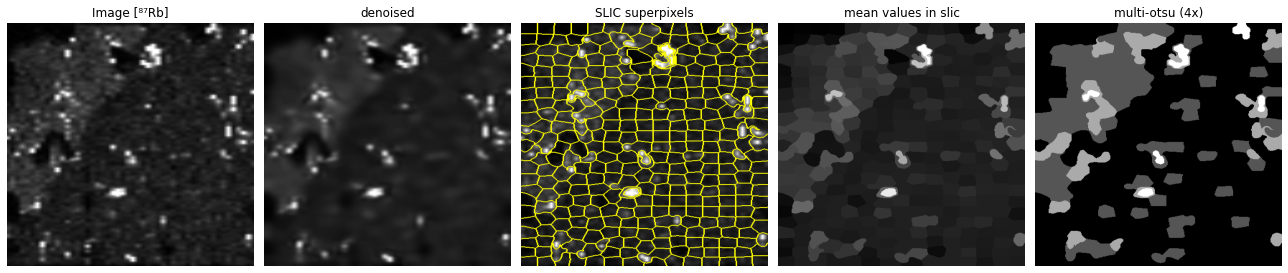

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


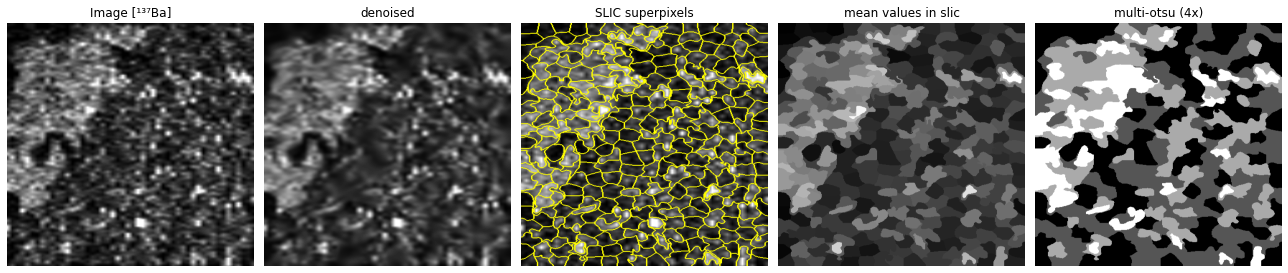

In [13]:
denoised_dict = {}
segments_slic_dict = {}
mean_slic_dict = {}
regions_dict = {}
print('start processing slic segments for simplified segmentation')
for i, element in enumerate(laser_data.elements.keys()):
    denoised_dict[element], segments_slic_dict[element], mean_slic_dict[element], regions_dict[element] = process_SLIC_of_element(element, show_results=True)#(i==len(laser_data.elements)-1) )


In [14]:
element = input('Select an element for segmentation. eg: V51')

print('Selected element for segmentation: {}'.format(element))

In [ ]:
#element = 'V51'
viewer = napari.Viewer()
new_layer = viewer.add_image(
    denoised_dict[element], 
    name='LA-ICP-MS [{}]'.format(laser_data.elements[element]), 
    scale=laser_data.scaling, 
    colormap=laser_data.get_color_by_element(element), 
    rendering="iso"
)
labels_layer = viewer.add_labels(
    regions_dict[element], 
    name='segmentation for {}'.format(laser_data.elements[element]), 
    scale=laser_data.scaling
)
input('Press "ENTER" if you are done with your segmentation to continue...')

Error: Session cannot generate requests

In [ ]:
"""
# mpo = mass-%-oxide
calibration_area_2 = {
    "Na23": {'mpo':   8683.914, 'ppm':  1.171},
    "Mg24": {'mpo':  23835.116, 'ppm':  3.953},
    "Al27": {'mpo':  14349.798, 'ppm':  2.711},
    "K39":  {'mpo':  78820.324, 'ppm':  9.495},
    "Ti47": {'mpo':   2923.188, 'ppm':  0.488},
    "V51":  {'mpo':  31937.183, 'ppm':  5.701},
    "Cr52": {'mpo':  33360.189, 'ppm':  4.876},
    "Mn55": {'mpo':  43010.588, 'ppm':  5.554},
    "Zn66": {'mpo':   4230.290, 'ppm':  0.527},
    "Rb87": {'mpo': 157868.805, 'ppm': 18.741},
    "Ba137":{'mpo':   3505.525, 'ppm':  0.391}
}
calibration_area_3 = {
    "Na23": {'mpo':  18559.990, 'ppm':  2.502},
    "Mg24": {'mpo':  38431.882, 'ppm':  6.373},
    "Al27": {'mpo':  23078.091, 'ppm':  4.361},
    "K39":  {'mpo':  74258.320, 'ppm':  8.945},
    "Ti47": {'mpo':   4770.334, 'ppm':  0.796},
    "V51":  {'mpo':  47057.691, 'ppm':  8.401},
    "Cr52": {'mpo':  40771.331, 'ppm':  5.959},
    "Mn55": {'mpo':  79623.680, 'ppm': 10.281},
    "Zn66": {'mpo':   6433.280, 'ppm':  0.801},
    "Rb87": {'mpo': 231460.856, 'ppm': 27.477},
    "Ba137":{'mpo':   6907.159, 'ppm':  0.771}
}
"""
print()

Error: Session cannot generate requests

In [ ]:
import numpy as np

def summarize_calibrated_statistics( element, labels_layer, sum_pixel_selected, mask_selected, raw=False ):
    sum_ppm_selected = 0.0
    mean_mpo_selected = 0.0
    if sum_pixel_selected > 0:
        if raw:
            raw_img, _ = laser_data.optimize_img( laser_data.raw_image[element] )
            cal_img_ppm, cal_img_mpo = laser_data.get_calibrated_images(element, raw_img)
        else:
            cal_img_ppm, cal_img_mpo = laser_data.get_calibrated_images(element)

        concentration_in_selection = cal_img_ppm * labels_layer.data

        sum_ppm_selected = concentration_in_selection.sum()
        mean_mpo_selected = (cal_img_mpo*mask_selected).sum() / sum_pixel_selected

        """
        print('-'*20)
        print('Concentration of {} in the selected area ({:.1f} {}² / {} px)'.format(laser_data.elements[element], area, laser_data.unit, sum_pixel_selected ))
        print('   sum:            {:.1f} {}'.format(sum_ppm_selected, 'ppm'))
        #print('   sum per area:   {:.1f} {}/{}²'.format(sum_pixel_selected*pixel_area, 'ppm', unit))
        print(element)
        print(get_element_from_isotope( element ))
        print(laser_data.oxide_dict[get_element_from_isotope( element )])

        print('   mean m-% oxide: {:.6f} m.-%/px (calculated as {})'.format(mean_mpo_selected, laser_data.oxide_dict[get_element_from_isotope( element )]))
        print()
        """
    return sum_ppm_selected, mean_mpo_selected

def get_diagram(labels_layer, raw=False):
    layer_meta = []
    result = []
    for region_id in range(labels_layer.data.max()+1):
        mask_selected = np.where(labels_layer.data == region_id, 1, 0) # binary mask of the selection layer
        sum_pixel_selected = mask_selected.sum() # amount of segmented pixels in the binary mask
        area = laser_data.pixel_area * sum_pixel_selected
        #print('Layer #{} ({} px, {:.2f} {})'.format( region_id, sum_pixel_selected, sum_pixel_selected, laser_data.unit ))
        layer_meta.append([area, sum_pixel_selected])
        for element in laser_data.elements.keys():
            sum_ppm_selected, mean_mpo_selected = summarize_calibrated_statistics( element, labels_layer, sum_pixel_selected, mask_selected, raw )
            result_line = [region_id, element, sum_ppm_selected, mean_mpo_selected]
            result.append(result_line)
            
    region_id = -1
    fig = plt.figure()
    plt.rcParams['figure.figsize'] = [8, 8]
    ax = fig.add_axes([0,0,1,1])
    ax.set_yscale('log')
    colors = ['b','g', 'r', 'grey']
    width = 0.2
    for result_line in result:
        if result_line[0] != region_id:
            if region_id >= 0:            
                ax.bar(np.arange(len(isotopes))+(width*region_id), data, width= width, color=colors[region_id], label="Layer #{}".format(region_id))
            region_id = result_line[0]
            data     = []
            isotopes = []
            #print()
            #print('Layer #{} ({} px, {:.2f} {})'.format( region_id, layer_meta[region_id][1], layer_meta[region_id][0], laser_data.unit ))
            #pos = result_line[0]
        data.append(result_line[3])
        isotopes.append(result_line[1])

    ax.bar(np.arange(len(isotopes))+(width*region_id), data, width= width, color=colors[region_id], label="Layer #{}".format(region_id))
    ax.set_xticks(np.arange(len(isotopes)) + width / 2)
    ax.set_xticklabels(laser_data.elements.values())# isotopes)
    ax.legend()
    plt.show()

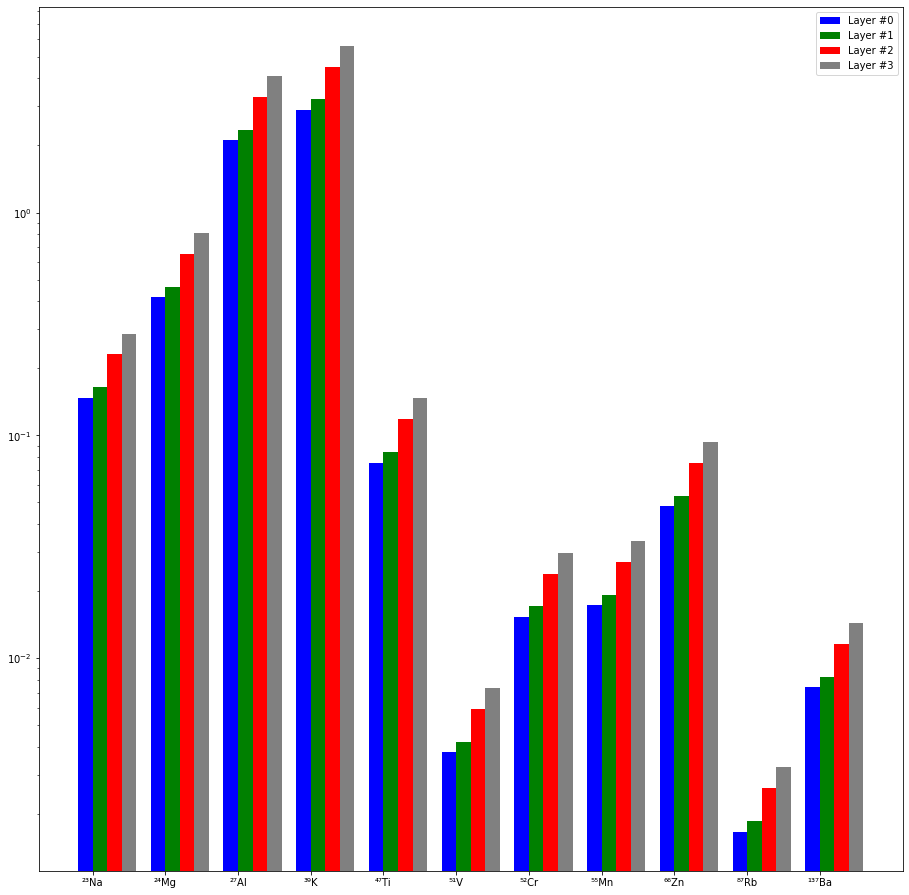

In [ ]:
get_diagram(labels_layer, raw=False)

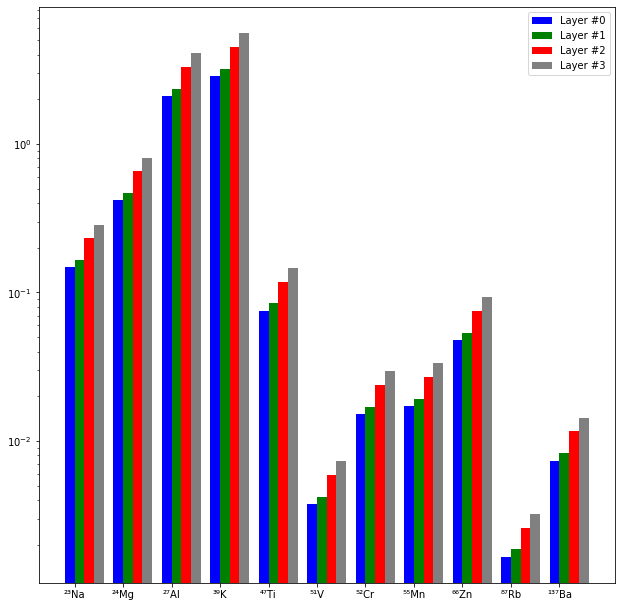

In [ ]:
get_diagram(labels_layer, raw=True)


In [ ]:
print(len(laser_data.raw_image[element][0]), len(laser_data.raw_image[element]))

519 50


In [ ]:
print(laser_data.np_images[element].shape)


(519, 344)


In [ ]:
laser_data.show_single_image(element='V51')

Error: Session cannot generate requests